In [66]:
import matplotlib.pyplot as plt
import numpy as np
import unittest
%matplotlib inline

In [4]:
from skimage.feature import hog

def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=True, feature_vector=feature_vec)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                       visualise=False, feature_vector=feature_vec)
        return features

In [25]:
def get_gray_img(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return gray

In [19]:
def crop_img(img, keep_below=350):
    return img[keep_below:,:]

In [48]:
import glob
def get_vehicles():
    return glob.glob('./vehicles/**/*.png')

def get_non_vehicles():
    return glob.glob('./non-vehicles/**/*.png')


/Users/kevinwestern/anaconda/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


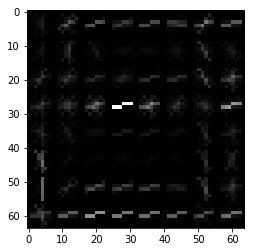

In [44]:
import cv2
gray = get_gray_img('./vehicles/GTI_MiddleClose/image0000.png')
features, hog_image = get_hog_features(gray, 9, 8, 2, vis=True)
plt.imshow(hog_image, cmap='gray')

# of vehicles: 8792
# of non-vehicles: 8968


/Users/kevinwestern/anaconda/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


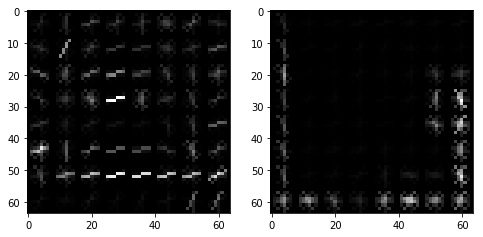

In [55]:
vehicles = get_vehicles()
non_vehicles = get_non_vehicles()

gray_vehicle = get_gray_img(vehicles[0])
vehicle_features, vehicle_hog_image = get_hog_features(gray_vehicle, 9, 8, 2, vis=True)

gray_non_vehicle = get_gray_img(non_vehicles[0])
non_vehicle_features, non_vehicle_hog_image = get_hog_features(gray_non_vehicle, 9, 8, 2, vis=True)

print('# of vehicles: %d' % len(vehicles))
print('# of non-vehicles: %d' % len(non_vehicles))

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
ax = ax.ravel()
ax[0].imshow(vehicle_hog_image, cmap='gray')
ax[1].imshow(non_vehicle_hog_image, cmap='gray')

In [60]:
def extract_features(imgs, cspace='RGB', orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = cv2.cvtColor(cv2.imread(file), cv2.COLOR_BGR2RGB)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        features.append(hog_features)
    # Return list of feature vectors
    return features

#### Make sure extract_features is working as expected.

In [88]:
vehicles = [get_vehicles()[0]]
extracted_features = extract_features(vehicles)
img = cv2.cvtColor(cv2.imread(vehicles[0]), cv2.COLOR_BGR2RGB)
hog_features = [get_hog_features(img[:,:,0], 9, 8, 2)]
np.testing.assert_array_equal(extracted_features, hog_features)

/Users/kevinwestern/anaconda/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


#### Now let's load the cars and non cars data

In [89]:
car_features = extract_features(get_vehicles())
non_car_features = extract_features(get_non_vehicles())

/Users/kevinwestern/anaconda/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


#### And create our features and labels

In [91]:
from sklearn.preprocessing import StandardScaler

# Create rows of features
# np.vstack([1,2], [3,4]) ->
# [[1,2],
#  [3,4]]
X = np.vstack((car_features, non_car_features)).astype(np.float64)
X_scaler = StandardScaler().fit(X)
scaled_X = X_scaler.transform(X)

# Create labels
# np.hstack([1,2],[3,4]) ->
# [1,2,3,4]
y = np.hstack((np.ones(len(car_features)), np.zeros(len(non_car_features))))

#### And split it up

In [97]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, shuffle=True)

#### Now build a model since we have training and test data.

In [98]:
from sklearn.svm import LinearSVC

svc = LinearSVC()
svc.fit(X_train, y_train)
accuracy = svc.score(X_test, y_test)
print('Accuracy of %f' % accuracy)

Accuracy of 0.937500


In [141]:
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                 xy_window=(256, 256), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list


In [142]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

In [143]:
img = cv2.imread('./test_images/test1.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
windows = slide_window(img)

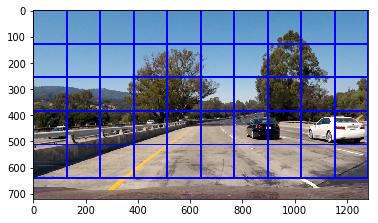

In [144]:
plt.imshow(draw_boxes(img, windows))